In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Finding Customers Where We Should Limit Credit Limit

 Just finding the customers that are about to default is not enough,
 because in the end we would like to prevent defaults from happening
 and even if a customer has a high immediate risk of default we might
 not have any leverage to change her behavior at this point. Where
 we would have leverage is in the moment when we are setting
 the customers credit limit before things escalated.

 If we could find customers where giving them a lower credit limit
 would prevent their future default by preventing them from taking
 a loan that too big for them to handle, we would have an option
 to act on these predictions.

 The data that we have pertains to the immediate risk of defaulting,
 but we can use this data to simulate a situation where we are
 setting the customers their credit limits (probably years before the possible
 default) by just considering the demographic information of the customer.

 Because the data that we use is so limited we would predict that
 the results will not be spectacular, but this should be seen more
 as a proof of concept. If we can find customers where the credit
 limit should be lower and also find how much lower the limit should
 be only with this limited dataset, we can be sure that with a richer
 dataset containing all the variables that we actually use when
 making decisions about credit limit we can create a valuable
 tool for preventing defaults.

In [1]:

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scikitplot as skplt
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from IPython.core.interactiveshell import InteractiveShell
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from src.optimization.credit_limit import (
    calculate_effect_of_credit_drop,
    form_results_to_ordered_df,
    order_effects_within_customers,
)

# Setting styles
InteractiveShell.ast_node_interactivity = "all"
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})
# we don't want to have dark background in our saved plots
matplotlib.rcParams.update(_VSCode_defaultMatplotlib_Params)

random_state = 123


/home/tuomo/anaconda3/envs/credit-risk-prediction/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/tuomo/anaconda3/envs/credit-risk-prediction/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


 # Loading the Data and Choosing Columns

 We only keep demographic factors + credit limit and if the customer defaulted
 * sex
 * age
 * education
 * marital status
 * credit given
 * default

In [2]:

df = pd.read_csv(os.path.join("data", "processed", "training.csv"), index_col="ID")
df_validation = pd.read_csv(
    os.path.join("data", "processed", "validation.csv"), index_col="ID"
)

cols = ["credit_given", "sex", "education", "marriage", "age", "defaulted"]

df = df[cols]
df_validation = df_validation[cols]

# There are a few missing values and dropping them makes other stuff easier
# without affecting the amount of data much
df.dropna(inplace=True)
df_validation.dropna(inplace=True)
# many of our models can only handle numerical values so dummifying
df = pd.get_dummies(df, prefix=["sex", "education", "marriage"])
df_validation = pd.get_dummies(df_validation, prefix=["sex", "education", "marriage"])

X_train = df.drop(columns="defaulted")
y_train = df["defaulted"]

X_validation = df_validation.drop(columns="defaulted")
y_validation = df_validation["defaulted"]


 # Credit Limit Affects the Default Probability

 Building a XGBoost model with the credit limit included or not, we see that
 dropping the credit limit leads significantly worse model measured by ROC AUC

 Checking the the Shapley value summary of the model with credit limit
 included shows us that credit limit is the feature with the highest influence.
 It also shows unfortunately shows that for most customers the model
 predicts lower defaulting risk for customers with higher credit limits.
 This does not of course make sense and is because significantly more
 information than just the demographic information that we use here
 went into to choosing the credit limit. This means that the credit limit
 comes with lots of information about the customer baked in that we otherwise
 have no access to. This should not happen if we would have access to more
 information about the customer and could better distinguish the effect of the
 credit limit and the factors that affect the how high the credit limit was
 set.

 Even though the credit though the model would predict that a higher credit
 limit would prevent defaults, this should not be the case for all customers
 we would like to find the customer groups that even with the limited amount
 of demographic data available have a credit limit that seems too high.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=123, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=123, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

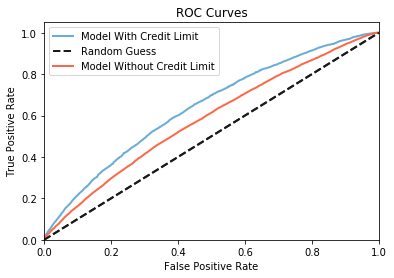

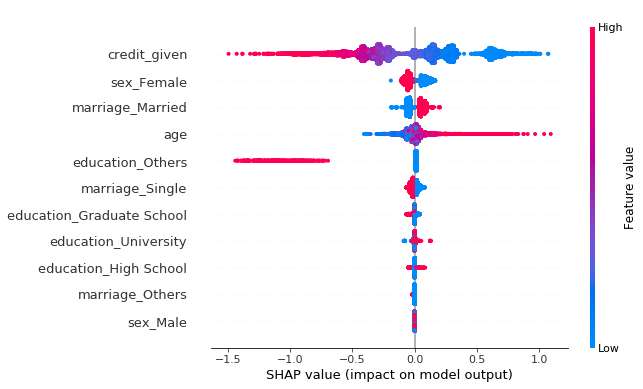

In [3]:

xgb_credit_limit = XGBClassifier(random_state=random_state, objective="binary:logistic")
xgb_credit_limit.fit(X_train, y_train)
xgb_credit_limit_pred = xgb_credit_limit.predict_proba(X_train)

xgb_no_credit_limit = XGBClassifier(
    random_state=random_state, objective="binary:logistic"
)
xgb_no_credit_limit.fit(X_train.drop(columns="credit_given"), y_train)
xgb_no_credit_limit_pred = xgb_no_credit_limit.predict_proba(
    X_train.drop(columns="credit_given")
)

fig, ax = plt.subplots()
skplt.metrics.plot_roc(
    y_train,
    xgb_credit_limit_pred,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    cmap="Blues",
)
skplt.metrics.plot_roc(
    y_train,
    xgb_no_credit_limit_pred,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    cmap="Reds",
)
plt.legend(["Model With Credit Limit", "Random Guess", "Model Without Credit Limit"])
plt.show()

# load JS visualization code to notebook
shap.initjs()

explainer = shap.TreeExplainer(xgb_credit_limit)
shap_values = explainer.shap_values(X_train)

# visualize the training set predictions
shap.summary_plot(shap_values, X_train)


 # Training Models

 We want to the best model to predict defaulting with the data that we have.
 We try three different models: XGBoost, random forest and CatBoost.

 On top of the
 overall AUC of the model we are interested in the Lift curve of the models.
 This is because we would most likely end up targeting the credit limits of customers
 that have a high change of defaulting and it is possible that a model would quite
 inaccurate overall, but would be extremely good for finding a small proportion of
 the defaulters. This kind of model would be better for our purposes.

 The last metric that we are interested in is how well the predicted probabilities
 of the models are tuned. We need these to closely match reality as if this
 is not the case the futher calculations about how the lowering the credit
 limit would lower the change of defaulting would not be on solid ground.

 We train the models on training data and then calculate all the metrics
 with a separate holdout set that we have not used before this. This makes
 our metrics align closely with performance that we should expect if we would
 apply the models to unseen new data.

In [4]:

# hyperparameters come from a separate tuning phase
xgb_model = XGBClassifier(
    random_state=random_state,
    objective="binary:logistic",
    gamma=20,
    max_depth=2,
    seed=random_state,
    nthread=-1,
)

# we care that the predicted probabilites are well tuned and we need to
# adjust this separately for random forests
rf_model = CalibratedClassifierCV(
    RandomForestClassifier(
        random_state=random_state,
        max_depth=1,
        min_samples_split=9,
        n_estimators=1000,
        n_jobs=-1,
        class_weight="balanced",
    ),
    cv=5,
)

cat_model = CatBoostClassifier(
    l2_leaf_reg=3,
    depth=4,
    loss_function="Logloss",
    verbose=False,
    random_state=random_state,
)


In [5]:

xgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict_proba(X_validation)
rf_pred = rf_model.predict_proba(X_validation)
cat_pred = cat_model.predict_proba(X_validation)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=20, learning_rate=0.1,
       max_delta_step=0, max_depth=2, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=123, silent=None, subsample=1, verbosity=1)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=1, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=9, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False,
            random_state=123, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

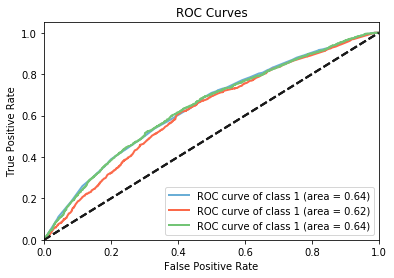

In [6]:

fig, ax = plt.subplots()
skplt.metrics.plot_roc(
    y_validation,
    xgb_pred,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    cmap="Blues",
)
skplt.metrics.plot_roc(
    y_validation,
    rf_pred,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    cmap="Reds",
)
skplt.metrics.plot_roc(
    y_validation,
    cat_pred,
    plot_micro=False,
    plot_macro=False,
    classes_to_plot=[1],
    ax=ax,
    cmap="Greens",
)
plt.savefig(os.path.join("reports", "figures", "roc_curves.png"))
plt.show()


/home/tuomo/anaconda3/envs/credit-risk-prediction/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


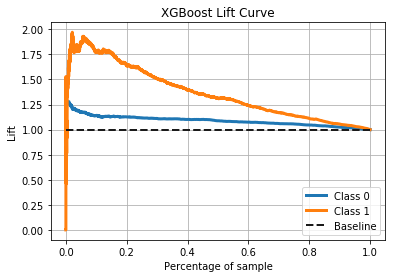

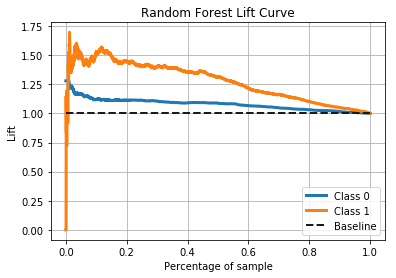

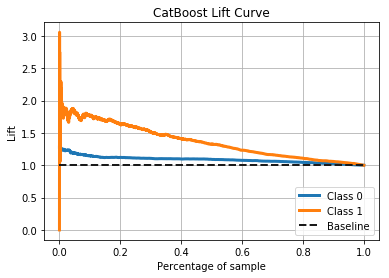

In [7]:

skplt.metrics.plot_lift_curve(y_validation, xgb_pred, title="XGBoost Lift Curve")
plt.savefig(os.path.join("reports", "figures", "xgboost_lift_curve.png"))
plt.show()
skplt.metrics.plot_lift_curve(y_validation, rf_pred, title="Random Forest Lift Curve")
plt.savefig(os.path.join("reports", "figures", "randomforest_lift_curve.png"))
plt.show()
skplt.metrics.plot_lift_curve(y_validation, cat_pred, title="CatBoost Lift Curve")
plt.savefig(os.path.join("reports", "figures", "catboost_lift_curve.png"))
plt.show()


[<matplotlib.lines.Line2D at 0x7efd3cc68860>]

[<matplotlib.lines.Line2D at 0x7efd3cc68358>]

[<matplotlib.lines.Line2D at 0x7efd3cc3b9e8>]

[<matplotlib.lines.Line2D at 0x7efd3cc3bdd8>]

Text(0.5, 0, 'Predicted Probability of Defaulting')

Text(0, 0.5, 'Actual Chance of Defaulting')

Text(0.5, 1.0, 'Calibration plot')

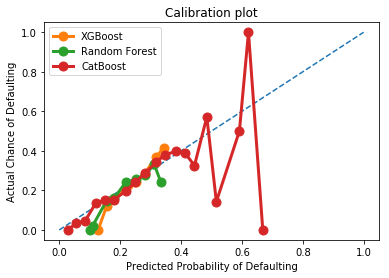

In [8]:

xgb_fop, xgb_mpv = calibration_curve(
    y_validation, xgb_pred[:, 1], normalize=False, n_bins=30
)
random_forest_fop, random_forest_mpv = calibration_curve(
    y_validation, rf_pred[:, 1], normalize=False, n_bins=30
)
cat_fop, cat_mpv = calibration_curve(
    y_validation, cat_pred[:, 1], normalize=False, n_bins=30
)

fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], linestyle="--")
ax.plot(xgb_mpv, xgb_fop, linewidth=3, marker=".", markersize=18, label="XGBoost")
ax.plot(
    random_forest_mpv,
    random_forest_fop,
    linewidth=3,
    marker=".",
    markersize=18,
    label="Random Forest",
)
ax.plot(cat_mpv, cat_fop, linewidth=3, marker=".", markersize=18, label="CatBoost")
plt.legend()
plt.xlabel("Predicted Probability of Defaulting")
plt.ylabel("Actual Chance of Defaulting")
plt.title("Calibration plot")
plt.savefig(os.path.join("reports", "figures", "calibration_plot.png"))
plt.show()



 # Finding the Best Candidates for Lower Credit

 Next we create lots of possible scenarios of by lowering the credit limit of
 customers by a percent amount. Then we predict the default probability of these
 hypothetical cases with our previously trained models. By compating the predicted
 default risks between the actual case and the hypothetical case we will can see
 how the model predicts that changing the credit limit would affect the default
 risk of each customer. Because we test multiple different credit limit
 drops we can not just find the customers where dropping the credit limit would
 be advantageous, but also see how much we should drop the credit for these
 customers.

 After these calculations we optimize for each model the best way to drop
 the credit defaulting rate with the minimum amount of credit limit change. We would
 like to make us small as possible change to the sum of all credit given. This means
 that we optimize for the biggest change in the percent change of defaulting per dollar
 in credit lost. We don't just put the customers in order in with this metric, but also
 it is likely that there multiply different sizes of credit limit drops for each
 customer and we also consider these in our optimization.

 The end results of the analysis are two kinds of plots. One showing the drop of
 predicted # defaults in percentage points versus the percentage of credit given
 lost. The other graph shows the percentage of customers affected by type
 (defaulters, non-defaulters and all customers). On the X-axis are the number
 of steps of credit lowering taken. These are made in the optimized order
 explained above that is calculated for each model separately. Each step usually
 means targeting a new customer, but sometimes also dropping the credit limit
 for a customer where the limit has already been dropped be before. This means
 that, altough highly related, the number of steps does not relate to the number
 of customers affected in a straightforward manner.

[<matplotlib.lines.Line2D at 0x7efd3c9bb6a0>]

[<matplotlib.lines.Line2D at 0x7efd3c9bba90>]

(0, 1000)

Text(0.5, 1.0, 'XGBoost: Defaults Avoided vs Defaults Cost in Credit')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

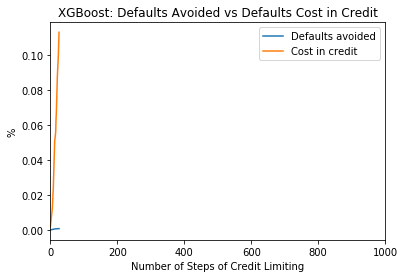

[<matplotlib.lines.Line2D at 0x7efd3c902da0>]

[<matplotlib.lines.Line2D at 0x7efd3c90a278>]

[<matplotlib.lines.Line2D at 0x7efd3c90a780>]

(0, 1000)

Text(0.5, 1.0, 'XGBoost: Proportion of Different Types of Customers affected')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

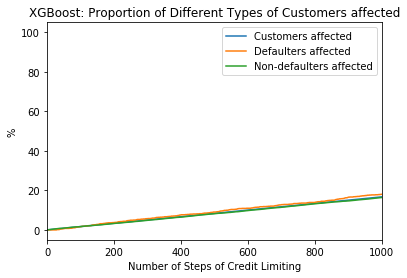

[<matplotlib.lines.Line2D at 0x7efd3c9ef9b0>]

[<matplotlib.lines.Line2D at 0x7efd3c9ef3c8>]

(0, 1000)

Text(0.5, 1.0, 'Random Forest: Defaults Avoided vs Defaults Cost in Credit')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

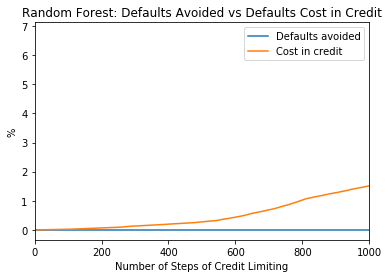

[<matplotlib.lines.Line2D at 0x7efd445900b8>]

[<matplotlib.lines.Line2D at 0x7efd445da240>]

[<matplotlib.lines.Line2D at 0x7efd445da0f0>]

(0, 1000)

Text(0.5, 1.0, 'Random Forest: Proportion of Different Types of Customers affected')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

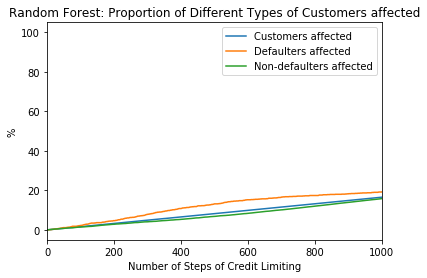

[<matplotlib.lines.Line2D at 0x7efd3c930940>]

[<matplotlib.lines.Line2D at 0x7efd3c936a90>]

(0, 1000)

Text(0.5, 1.0, 'CatBoost: Defaults Avoided vs Defaults Cost in Credit')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

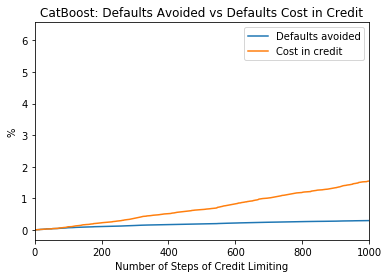

[<matplotlib.lines.Line2D at 0x7efd4458b5c0>]

[<matplotlib.lines.Line2D at 0x7efd4458ba58>]

[<matplotlib.lines.Line2D at 0x7efd4458be10>]

(0, 1000)

Text(0.5, 1.0, 'CatBoost: Proportion of Different Types of Customers affected')

Text(0.5, 0, 'Number of Steps of Credit Limiting')

Text(0, 0.5, '%')

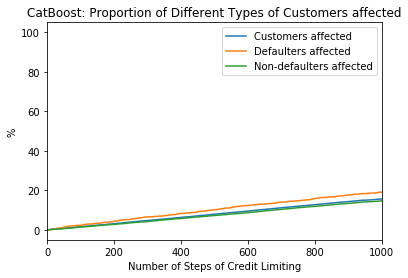

In [9]:

models = [xgb_model, rf_model, cat_model]
model_names = ["XGBoost", "Random Forest", "CatBoost"]
credit_limit_factors = np.around(np.arange(0.7, 0.90, 0.1), 2)

for model_name, model in zip(model_names, models):

    (
        all_probs_changes,
        all_credit_amount_changes,
        all_expected_costs_in_credit,
    ) = calculate_effect_of_credit_drop(
        model=model, X=X_validation, credit_factors=credit_limit_factors
    )

    (
        all_processed_costs,
        all_processed_factors,
        all_processed_credit_changes,
        all_processed_probs_changes,
    ) = order_effects_within_customers(
        X=X_validation,
        credit_factors=credit_limit_factors,
        all_probs_changes=all_probs_changes,
        all_credit_amount_changes=all_credit_amount_changes,
        all_expected_costs_in_credit=all_expected_costs_in_credit,
    )

    costs_df = form_results_to_ordered_df(
        y=y_validation,
        X=X_validation,
        probs=model.predict_proba(X_validation)[:, 1],
        all_processed_costs=all_processed_costs,
        all_processed_factors=all_processed_factors,
        all_processed_credit_changes=all_processed_credit_changes,
        all_processed_probs_changes=all_processed_probs_changes,
    )

    plt.plot(costs_df.defaults_prevented_perc, label="Defaults avoided")
    plt.plot(costs_df.credit_cost_perc, label="Cost in credit")
    plt.xlim([0, 1000])
    plt.title(model_name + ": Defaults Avoided vs Defaults Cost in Credit")
    plt.xlabel("Number of Steps of Credit Limiting")
    plt.ylabel("%")
    plt.legend()
    plt.savefig(
        os.path.join(
            "reports", "figures", model_name.lower().strip() + "_defaults_vs_costs.png"
        )
    )
    plt.show()

    plt.plot(costs_df.customers_affected_perc, label="Customers affected")
    plt.plot(costs_df.defaulters_affected_perc, label="Defaulters affected")
    plt.plot(costs_df.non_defaulters_affected_perc, label="Non-defaulters affected")
    plt.xlim([0, 1000])
    plt.title(model_name + ": Proportion of Different Types of Customers affected")
    plt.xlabel("Number of Steps of Credit Limiting")
    plt.ylabel("%")
    plt.legend()
    plt.savefig(
        os.path.join(
            "reports",
            "figures",
            model_name.lower().strip() + "_types_of_customers_affected.png",
        )
    )
    plt.show()


 # Futher Exploration of CatBoost

 The CatBoost model seems to have the best results of the models. So we would
 probably like to know a bit more about it. For this reason we plot the Shapley
 values of this models. We see the familiar problem of higher credit limits
 mostly predicting the lower default rates. We know though that this is not
 the case for all customers as we would have not find any possibilities to
 drop credit limits that lower the chance of defaulting in the previous step.

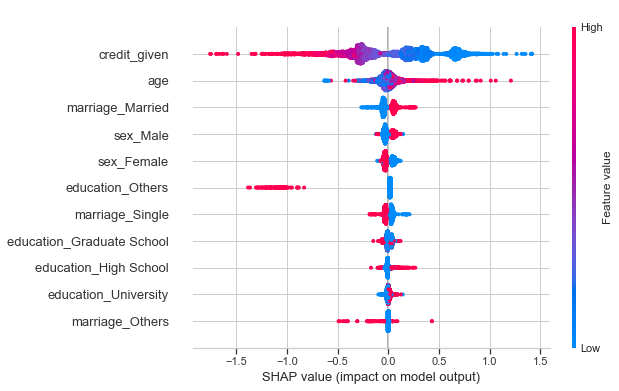

In [10]:

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_validation)

# visualize the training set predictions
sns.set(style="whitegrid", color_codes=True, rc={"figure.figsize": (12.7, 9.27)})

fig = shap.summary_plot(shap_values, X_validation, show=False)
plt.savefig(os.path.join("reports", "figures", "catboost_shap_all_features.png"))
plt.show()


 # Conclusions

 * The method for finding the customers where we should lower the credit limit
 work in concept
 * To do a proper of the viability of the concept we would need to have access to the
 same variables that are used when the credit limit is decided for building the models
 * The ultimate goal would be to create a system that could warn our employers when
 they are about to approve a credit limit that is too big and suggest them a suitably
 lower credit limit that is big enough to have a meaningfull effect on the probability
 of default without denying the customer credit completely